# Análise de sentimentos em tweets



## 1. Dataset
A análise de sentimentos é um processo automático para determinar a polaridade de sentimento de um texto. Essa técnica
tem um valor comercial pautado no fato de que a partir dela é possível ter uma visão geral do público sobre determinado assunto a partir de tweets. Assim, possibilitando a empresa a estudar as opiniões de seu público e analisar a satisfação do consumidor. No estudo a seguir, será utilizado um classificador para determinar a classe de cada um dos tweets do dataset [Processed twitter sentiment Dataset | Added Tokens](https://www.kaggle.com/datasets/halemogpa/processed). como positivo ou negativo.

## 2. Pipeline

### Pré-processamento

In [28]:
# ===== carregando bibliotecas e funções ===== #
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# nltk para pré-processamento
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\livia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [29]:
# carregando o dataset
df = pd.read_csv("data/train-processed.csv")

df.head()

,text,sentiment,tokens
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,"['@switchfoot', 'http://twitpic.com/2y1zl', '-..."
1,is upset that he can't update his Facebook by ...,0,"['is', 'upset', 'that', 'he', 'ca', ""n't"", 'up..."
2,@Kenichan I dived many times for the ball. Man...,0,"['@kenichan', 'i', 'dived', 'many', 'times', '..."
3,my whole body feels itchy and like its on fire,0,"['my', 'whole', 'body', 'feels', 'itchy', 'and..."
4,"@nationwideclass no, it's not behaving at all....",0,"['@nationwideclass', 'no', ',', 'it', ""'s"", 'n..."


O número de tweets negativos e positivos está bem equilibrado, tendo apenas 8 tweets de diferença entre uma classificação e outra. E não há linhas com valores nulos.

In [30]:
# Subconjunto com sentiment 0
df_sentiment_0 = df[df['sentiment'] == 0]

# Subconjunto com sentiment 1
df_sentiment_1 = df[df['sentiment'] == 1]

# Amostra 10.000 de cada (ajustando o valor se seu DataFrame tiver menos de 10.000 em cada classe)
sample_0 = df_sentiment_0.sample(n=20000, random_state=42)
sample_1 = df_sentiment_1.sample(n=20000, random_state=42)

# Concatenando as amostras para criar um DataFrame balanceado
balanced_sample = pd.concat([sample_0, sample_1])

# Embaralhando as linhas para garantir que não haja ordem implícita
df_balanced = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
print(df_balanced["sentiment"].value_counts())
print()
df_balanced.info()

sentiment
1    20000
0    20000
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
 2   tokens     40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


### Peculiaridades dos tweets

#### Username
No twitter, assim como em outras redes sociais, é comum se referenciar a outros usuários colocando o nome do user com '@' na frente, por exemplo "@liviatanaka". Como o nome do user não é algo que influencia no sentimento do tweet em si, vamos trocar as ocorrências de tokens que começam com @ pela palavra "username", para então diminuir essa variedade de palavras que não trazem grande significado, por uma palavra que represente todas essas menções de modo que a frase não mude de sentido pela ausência da menção.

#### URL

Além disso, é muito comum que se mencione URLS nos tweets e assim como os usernames o contéudo presente na URL em si não traz informações relevantes quanto ao sentimento do usuário. Por isso, foi trocado todas os tokens que começam com "http" por "url".

#### Letras repetidas
Outro fator que aparece em tweets é a repetição de letras para enfatizar uma palavra, como em `'i was checking my email...hrrrr....im so boooooored!!!  i miss my school'`.

O problema é que dessa forma os tokens "bored", "boooored" e "booooooored" são interpretados de maneiras diferentes, apesar de terem o mesmo significado. Diante disso, foi optado por diminuir o número de ocorrências de uma palavra, quando esse passava de 2. Assim, perdendo a enfâse porém focando no significado.

Dessa maneira, a frase do exemplo ficou como `'I was checking my email..hr..Im so bored!!  i miss my school'`

In [32]:
def number_of_tokens_in_dataset(df):
    return set([item for sublist in df.tokens for item in sublist]).__len__()

df_balanced['tokens'] = df_balanced['text'].apply(word_tokenize)

orginal_number = number_of_tokens_in_dataset(df_balanced)
print(f"Número de tokens no dataset original: {orginal_number}")

Número de tokens no dataset original: 61612


In [33]:

def remove_usernames(text):
    return re.sub(r'@[A-Za-z0-9_]+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+', 'url', text)

def remove_repeated_letters(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

def pre_processing(df): 
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].apply(remove_usernames)
    df['text'] = df['text'].apply(remove_urls)
    df['text'] = df['text'].apply(remove_repeated_letters)

    lemmatizer = WordNetLemmatizer()
    
    # retirar stopwords do texto
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in (stop_words)]))

    # tokenização
    df['tokens'] = df['text'].apply(word_tokenize)

    return df

In [34]:
df_ = df_balanced.copy()
pre_processing(df_)
df_.head()


,text,sentiment,tokens
0,"love miss friend(s), mention brother. thats mr...",1,"[love, miss, friend, (, s, ), ,, mention, brot..."
1,aww always miss good part bb,0,"[aww, always, miss, good, part, bb]"
2,know do! want see them. want copy,1,"[know, do, !, want, see, them, ., want, copy]"
3,ang hirap mo ireject! url,0,"[ang, hirap, mo, ireject, !, url]"
4,"haha definitely does, yumy.",1,"[haha, definitely, does, ,, yumy, .]"


In [35]:
processed_number = number_of_tokens_in_dataset(df_)
print(f"Número de tokens no dataset processado: {processed_number}")
print(f"Diferença de tokens: {orginal_number - processed_number}")

Número de tokens no dataset processado: 34116
Diferença de tokens: 27496


## Definição da pipeline
O modelo escolhido foi o bag-of-words (BoW), pois assume-se que, para esse caso, a ordem das palavras não é tão relevante. O mais importante é o significado de cada uma delas em relação a se é uma palavra com sentido positivo ou negativo. Para compor a pipeline, foi utilizado um vetorizador e um classificador. O vetorizador utilizado foi o CountVectorizer do scikit-learn com o max_features como 5000  , ele transforma os textos em vetores númericos contando o número de ocorrência das palavras. Já o classificador foi utilizado o método de regressão linear , no qual os coeficientes representam os pesos de cada uma das palavras, sendo essas as features para determinar se o texto possui a classe positiva (1) ou negativa (0). Para regressão, foi utilizado C como 0.1 e o max_iter como 1000.


In [36]:
# importando bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import balanced_accuracy_score, make_scorer 



In [37]:
# Separação do dataset entre treino e teste

X = df_['text']
y = df_['sentiment']
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2)


### Definindo os melhores parametros

In [38]:
# Definição da pipeline
test_pipe = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('model', LogisticRegression(max_iter=1000))
])

# Definição dos parâmetros a serem testados
param_grid = {
    'vectorizer__max_features': [ 5000, 10000, 15000],
    'model__C': [0.1, 1, 10],

}

# GridSearch com validação cruzada
grid_search = GridSearchCV(test_pipe, param_grid, cv=5, scoring='balanced_accuracy')
grid_search.fit(X_training, y_training)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia balanceada:", grid_search.best_score_)


Melhores parâmetros: {'model__C': 0.1, 'vectorizer__max_features': 5000}
Melhor acurácia balanceada: 0.7408251259742623


## 3. Avaliação do classificador

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
final_pipes = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000,  binary=True)),
    ('model', LogisticRegression(C=0.1, max_iter=1000))
])

scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score), 
}

results = cross_validate(final_pipes, X, y, cv=100, scoring=scoring, return_train_score=True)

In [41]:
print("Média de Balanced Accuracy no treino:", results['train_balanced_accuracy'].mean())
print("Média de Balanced Accuracy no teste:", results['test_balanced_accuracy'].mean())
print("Desvio padrão de Balanced Accuracy no treino:", results['train_balanced_accuracy'].std())
print("Desvio padrão de Balanced Accuracy no teste:", results['test_balanced_accuracy'].std())


Média de Balanced Accuracy no treino: 0.7897719696969697
Média de Balanced Accuracy no teste: 0.748225
Desvio padrão de Balanced Accuracy no treino: 0.000458671717477583
Desvio padrão de Balanced Accuracy no teste: 0.02090542692699673


### Matriz de confusão 
Na matriz de confusão é possível notar que o classificador tende a acertar praticamente a mesma quandidade de classificações para ambas as classes, negativa e positiva.

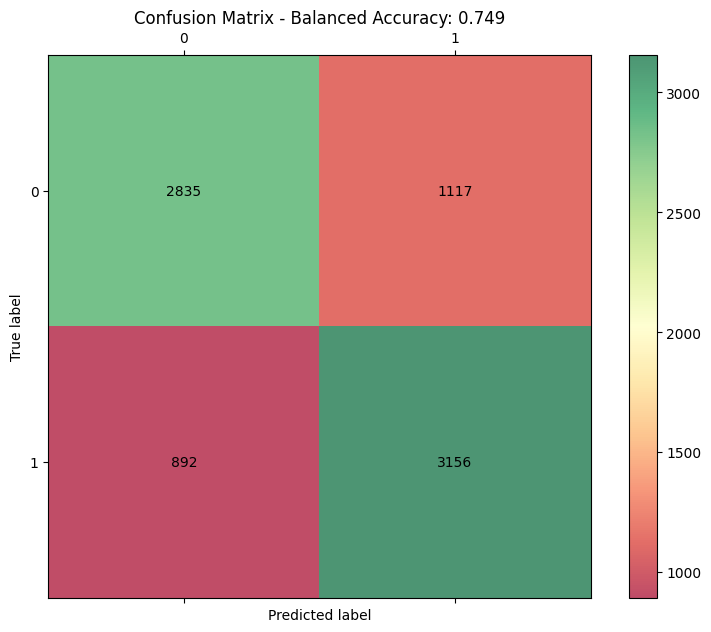

In [65]:

# realizando as predições
final_pipes.fit(X_training, y_training)
y_pred = final_pipes.predict(X_test)
accuracy = balanced_accuracy_score(y_test, y_pred)

# plotando a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=final_pipes.classes_)

plt.figure(figsize=(10, 7))
plt.matshow(cm, fignum=1, cmap='RdYlGn', alpha=0.7)

for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, f"{val:.0f}", ha='center', va='center')

plt.title(f"Confusion Matrix - Balanced Accuracy: {accuracy:.3f}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(len(final_pipes.classes_)), final_pipes.classes_)
plt.yticks(range(len(final_pipes.classes_)), final_pipes.classes_)
plt.colorbar()
plt.show()



Na figura acima é possível notar que há uma pequena diferença de resultado, posto que a classificação de textos como negativos tende a ter mais erros do que a de positivos. Uma hipótese para essa diferença é que textos com ironia, normalmente possuem um sentimento negativo expressado por palavras positivas. Por exemplo, frases como "What a great day to be run over by a bus!" e "I love when my phone autocorrects 'my name to 'smartass'" são classificadas como positivas.

In [43]:
test_model = grid_search.best_estimator_

print(test_model.predict(["What a great day to be run over by a bus!"]))
print(test_model.predict(["I love when my phone autocorrects 'my name to 'smartass'"]))



[1]
[1]


### Palavras mais importantes
As palavras negativas estão associadas a sentimentos de tristeza, saudade e dor.Já as positivas são, em geral, sentimentos de agradecimento e onomatopeias de risada e comemoração.

In [44]:

feature_names = final_pipes.named_steps['vectorizer'].get_feature_names_out()
coef = final_pipes.named_steps['model'].coef_

df_coef = pd.DataFrame(coef, columns=feature_names).T
df_coef.columns = ['Peso']

df_coef_positive = df_coef.sort_values(by='Peso', ascending=False)
df_coef_positive.head(5)



,Peso
thanks,1.448671
thank,1.343958
welcome,1.175617
yay,1.122639
hehe,1.002394


In [45]:
df_coef_negative = df_coef.sort_values(by='Peso', ascending=True)
df_coef_negative.head(5)

,Peso
sad,-2.340818
wish,-1.708286
sick,-1.560927
miss,-1.546740
hurt,-1.406317


## Avaliação do tamanho do dataset

In [46]:
# importando bibliotecas 
from sklearn.model_selection import learning_curve

In [57]:
scorer = make_scorer(balanced_accuracy_score)

train_sizes = np.linspace(0.05, 1.0, 20)

# Gerar as curvas de aprendizado
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=final_pipes, 
    X=X, 
    y=y, 
    train_sizes=train_sizes, 
    cv=10, 
    scoring=scorer, 
    n_jobs=-1
)


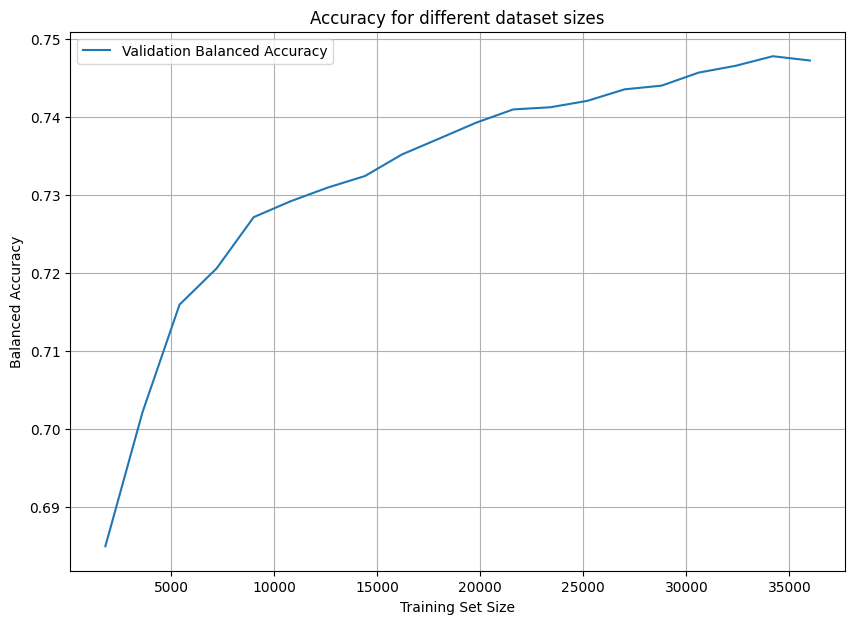

In [60]:

plt.figure(figsize=(10, 7))
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Validation Balanced Accuracy')
plt.title('Accuracy for different dataset sizes')
plt.xlabel('Training Set Size')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid()
plt.show()


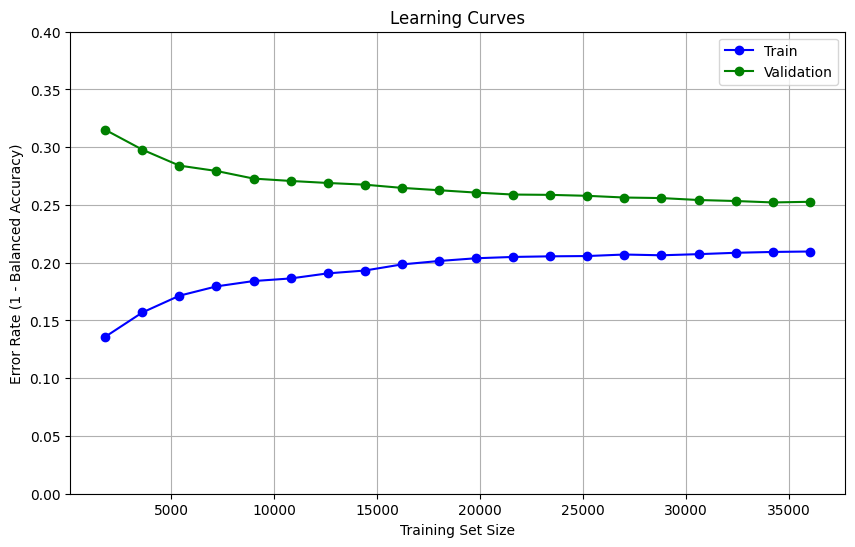

In [61]:

# calculando os erros
train_scores_errors = 1 - train_scores
valid_scores_errors = 1 - valid_scores

# calculando as médias e desvios padrão para treino e validação
train_mean = np.mean(train_scores_errors, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores_errors, axis=1)
valid_std = np.std(valid_scores, axis=1)

# gráfico das curvas de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Train", color="blue", marker="o")
plt.plot(train_sizes, valid_mean, label="Validation", color="green", marker="o")
plt.ylim(0, 0.4)


plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Error Rate (1 - Balanced Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


## Análise de Tópicos



In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF


In [67]:
topic_pipe = Pipeline([('vectorizer', CountVectorizer( stop_words="english", max_features=10000)),
                                    ('nmf', NMF()),
                                    ('classifier', LogisticRegression(max_iter=1000, C=1))])


param_grid = {
    'nmf__n_components': [2, 3, 4, 5, 6, 7, 8],
}

grid_search_topic = GridSearchCV(topic_pipe, param_grid, cv=5, scoring='balanced_accuracy')
grid_search_topic.fit(X_training, y_training)

print("Melhores parâmetros:", grid_search_topic.best_params_)
print("Melhor acurácia balanceada:", grid_search_topic.best_score_)



Melhores parâmetros: {'nmf__n_components': 6}
Melhor acurácia balanceada: 0.5638686125471774


In [68]:
cross_val_score(grid_search_topic.best_estimator_, X, y, cv=10, scoring='balanced_accuracy').mean()

np.float64(0.5720500000000001)

In [69]:
final_topic_pipe = grid_search_topic.best_estimator_
words = final_topic_pipe.named_steps['vectorizer'].get_feature_names_out()
for idx, topic in enumerate(final_topic_pipe.named_steps['nmf'].components_):
    print(f"Topic {idx}")
    for i in topic.argsort()[-5:]:
        print(words[i], f"{topic[i]:.2f}")
    print()
print()

Topic 0
got 2.51
going 2.77
time 2.86
today 3.13
work 4.17

Topic 1
new 0.15
song 0.15
amp 0.19
say 0.20
quot 6.69

Topic 2
mother 0.24
today 0.38
great 0.38
happy 0.49
day 5.86

Topic 3
feel 0.20
luck 0.27
night 0.73
morning 1.19
good 5.68

Topic 4
really 0.25
sound 0.32
look 0.76
feel 0.96
like 5.60

Topic 5
thanks 0.25
lt 0.29
new 0.48
url 3.06
love 4.12




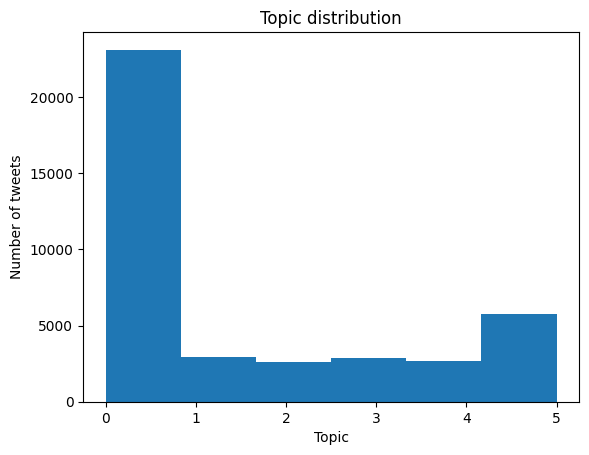

In [76]:

vectorizer = CountVectorizer(stop_words='english', max_features=5000, binary=True)
X_vec = vectorizer.fit_transform(X)

nmf = NMF(n_components=6) # n_components -> number of topics
X_nmf = nmf.fit_transform(X_vec) # matrix W

topic = np.argmax(X_nmf, axis=1)
plt.hist(topic, bins=len(set(topic)))
plt.title("Topic distribution")
plt.xlabel("Topic")
plt.ylabel("Number of tweets")
plt.show()
